#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

### **(1) 경로 설정**

* 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/project6/'

### **(2) 라이브러리 설치 및 불러오기**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [5]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [6]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [7]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.모델링**

In [8]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [9]:
def make_dataset_3(Product_ID):

  # 데이터 합치기
  temp1 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==Product_ID), ['Date','Qty']]
  temp2 = orders.loc[orders['Store_ID']==44, ['Date','CustomerCount']]
  temp3 = pd.merge(temp1, temp2)
  temp3['target'] = temp3['Qty'].shift(-2)  # 2일 후의 판매량
  temp3.dropna(inplace = True)

  # 날짜 요소 추출
  temp3['WeekDay'] = temp3['Date'].dt.day_name()
  temp3['Month'] = temp3['Date'].dt.month

  return temp3

In [10]:
def preproc3d_3(data, timesteps, y_scale = False) :
    target = 'target'
    x = data.drop(['Date', target], axis = 1)
    y = data.loc[:, target]

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x = pd.get_dummies(x, columns = ['WeekDay','Month'])
    col_names = list(x)


    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 60, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

In [11]:
df_3 = make_dataset_3(3)
df_3.head()

,Date,Qty,CustomerCount,target,WeekDay,Month
0,2014-01-02,9853.0,4422,15153.0,Thursday,1
1,2014-01-03,8647.0,4167,15606.0,Friday,1
2,2014-01-04,15153.0,5341,7900.0,Saturday,1
3,2014-01-05,15606.0,5123,7188.0,Sunday,1
4,2014-01-06,7900.0,3917,8800.0,Monday,1


* **모델링**

In [12]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d_3(df_3, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(2853.0, 25413.0, (1078, 7, 21), (60, 7, 21))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 32)               │           6,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 16)               │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,009 (43.00 KB)

 Trainable params: 11,009 (43.00 KB)

 Non-trainable params: 0 (0.00 B)

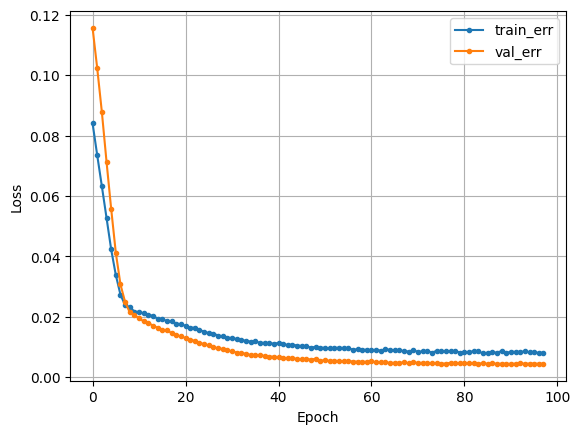

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

clear_session()

_, ts, nfeat = x_train.shape

model03_01 = Sequential([LSTM(32, input_shape=(ts, nfeat), return_sequences=True),
                         Dropout(0.2),
                         LSTM(16, return_sequences=True),
                         Dropout(0.2),
                         LSTM(8),
                         Dense(16, activation='relu'),
                         Dense(1)])
model03_01.summary()

model03_01.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

hist = model03_01.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0, callbacks=[early_stopping]).history

dl_history_plot(hist)

In [14]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_val)
pred2 = pred * (y_max - y_min) + y_min  # 예측값을 원래 스케일로 복원
y_val2 = y_val * (y_max - y_min) + y_min  # 실제값을 원래 스케일로 복원

print('RMSE : ', root_mean_squared_error(y_val,pred))
print('MAE : ', mean_absolute_error(y_val, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val, pred))
print('R2 : ',r2_score(y_val, pred))
print('------------------------')
print('RMSE : ', root_mean_squared_error(y_val2,pred2))
print('MAE : ', mean_absolute_error(y_val2, pred2))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred2))
print('R2 : ',r2_score(y_val2, pred2))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
RMSE :  0.11703701645634251
MAE :  0.08210222359209478
MAPE :  0.20450001810889304
R2 :  0.4910518587641537
------------------------
RMSE :  2640.355110804738
MAE :  1852.226163736979
MAPE :  0.1490578867178608
R2 :  0.4910518512274715


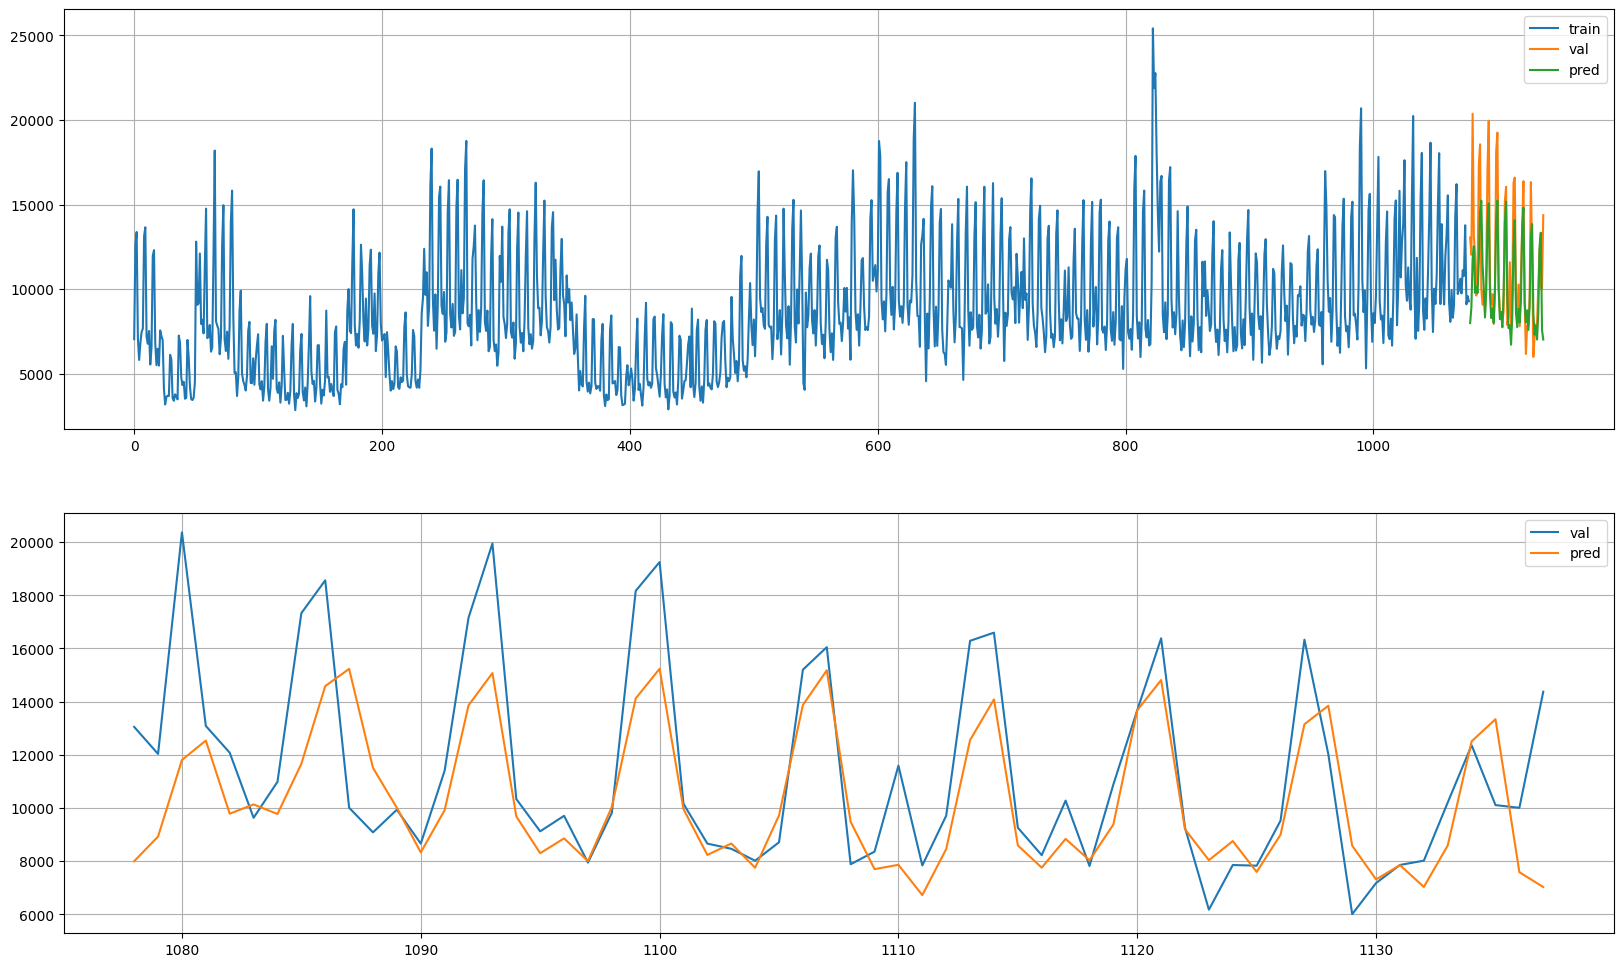

In [15]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred2)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [16]:
import joblib
df_12 = joblib.load('/content/drive/MyDrive/project6/파일 취합/data12_02.pkl')

In [17]:
def preproc3d_12(data, timesteps, y_scale=False):
    target = 'Target_Qty'
    scaled_columns = ['Qty', 'CustomerCount']

    # x와 y 분리
    x = data.drop(['Date', target], axis=1)
    y = data[target]

    # 스케일링 (특정 열만)
    scaler = MinMaxScaler()
    if any(col in x.columns for col in scaled_columns):
        # 스케일링할 컬럼이 있는 경우
        x[scaled_columns] = pd.DataFrame(
            scaler.fit_transform(x[scaled_columns]),
            columns=scaled_columns,
            index=x.index
        )

    # y 스케일링
    if y_scale:
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else:
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 데이터 분할 (시계열 데이터를 고려하여 분할)
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size=60, shuffle=False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max


In [18]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d_12(df_12, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(4390.0, 37106.0, (1080, 7, 4), (60, 7, 4))

* **모델링**

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

clear_session()

_, ts, nfeat = x_train.shape

# 모델 정의
model12_02 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(ts, nfeat)),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(16, return_sequences=False),  # 마지막 LSTM만 return_sequences=False
    Dense(8, activation='relu'),
    Dense(1)
])

# 모델 요약
model12_02.summary()

# 모델 컴파일
model12_02.compile(optimizer=Adam(learning_rate=0.005), loss='mse')


# Early Stopping 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,     # 성능이 개선되지 않는 에포크 수
    restore_best_weights=True  # 가장 좋은 모델의 가중치를 복원
)

# 모델 학습
hist = model12_02.fit(
    x_train, y_train,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
).history

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 64)               │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,361 (130.32 KB)

 Trainable params: 33,361 (130.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0131 - val_loss: 0.0110
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0117 - val_loss: 0.0108
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0115 - val_loss: 0.0108
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097 - val_loss: 0.0102
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0106 - val_loss: 0.0128
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0090 - val_loss: 0.0098
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0104 - val_loss: 0.0088
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0088 - val_loss: 0.0067
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0100 - val_loss: 0.0059
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0078 - val_loss: 0.0108
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0101 - val_loss: 0.0083
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 

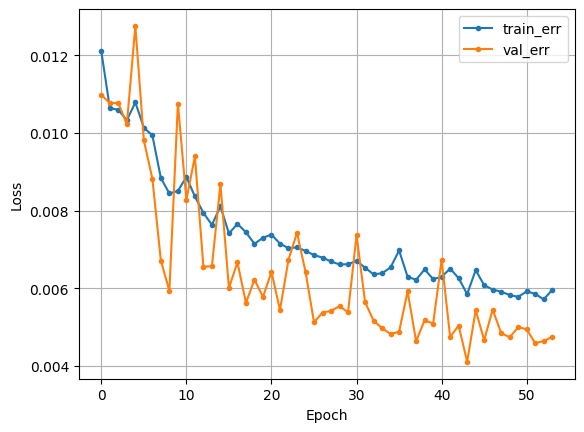

In [20]:
dl_history_plot(hist)

In [21]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_02.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
MAE :  2097.4602945963543
MAPE :  0.17192585130636662
R2 :  0.26159391924897735


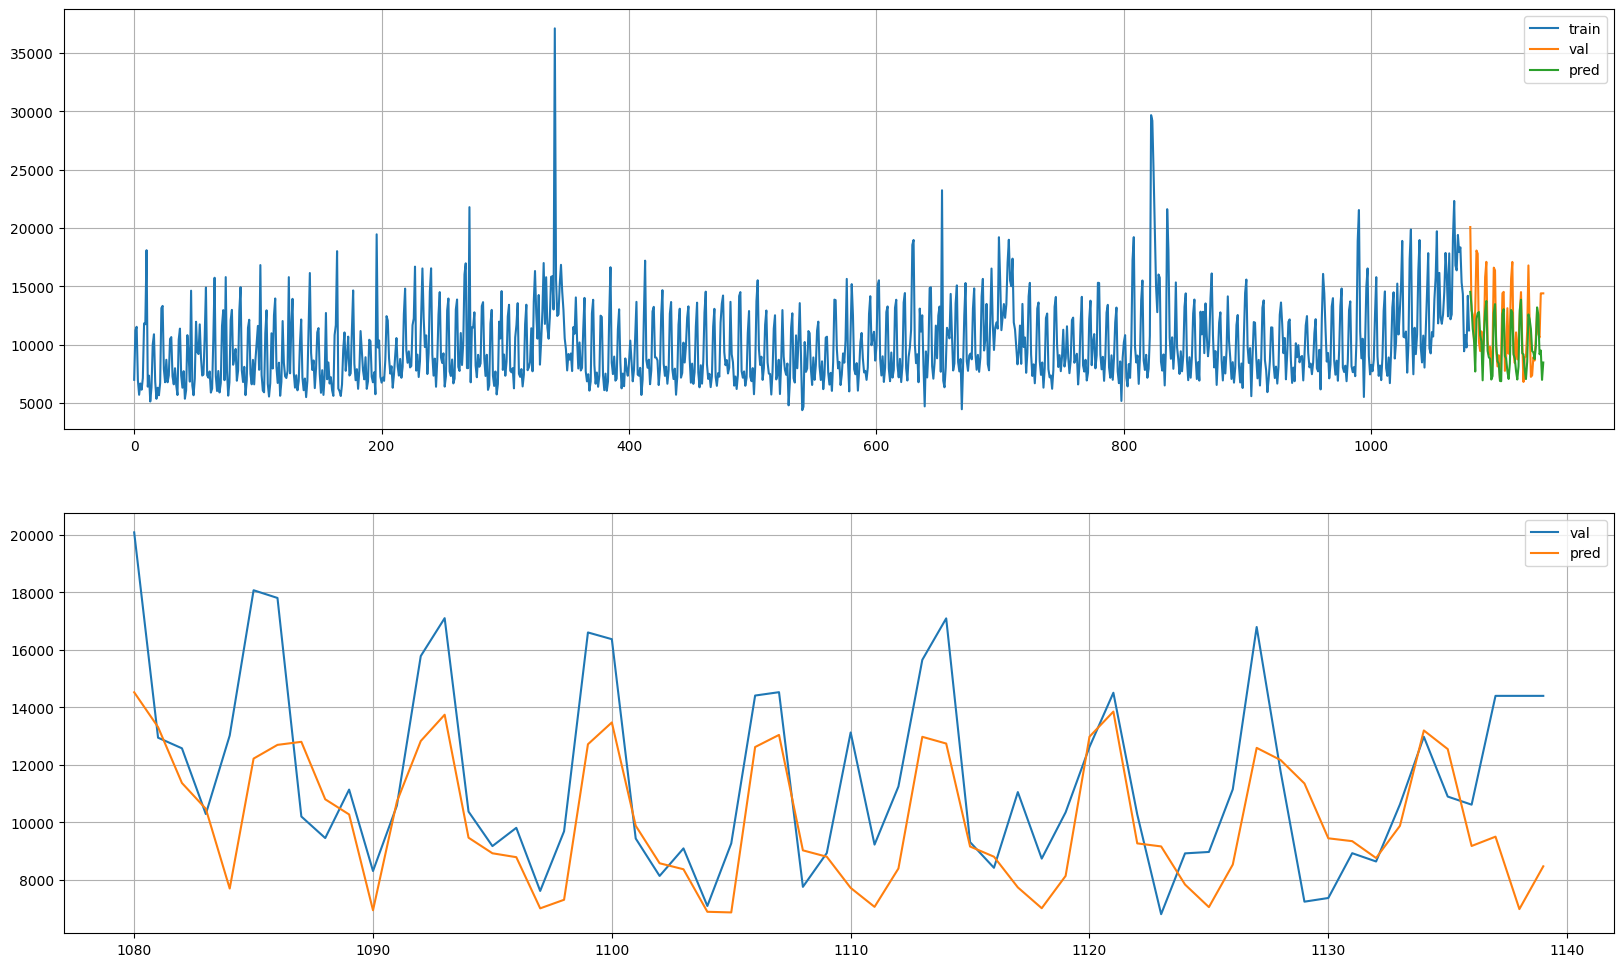

In [22]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [23]:
mydataset = joblib.load(path + '/파일 취합/myinterested_file_2.pkl')
mydataset

,Date,Qty,WTI_Price,CustomerCount,IsHoliday,IsOverQtyMonth,IsSummer,TotalPrice,year_2015,year_2016,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2014-01-01,51,95.14,3865,1,0,0,255,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-01-02,76,95.14,4422,0,0,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-01-03,74,93.66,4167,0,0,0,370,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2014-01-04,78,93.12,5341,1,0,0,390,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2014-01-05,88,93.12,5123,1,0,0,440,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,2017-02-24,91,53.99,4549,0,0,0,455,0,0,...,0,0,0,0,0,0,0,0,0,0
1151,2017-02-25,105,54.04,4619,1,0,0,525,0,0,...,0,0,0,0,0,0,0,0,0,0
1152,2017-02-26,108,54.04,3877,1,0,0,540,0,0,...,0,0,0,0,0,0,0,0,0,0
1153,2017-02-27,78,54.04,3961,0,0,0,390,0,0,...,0,0,0,0,0,0,0,0,0,0


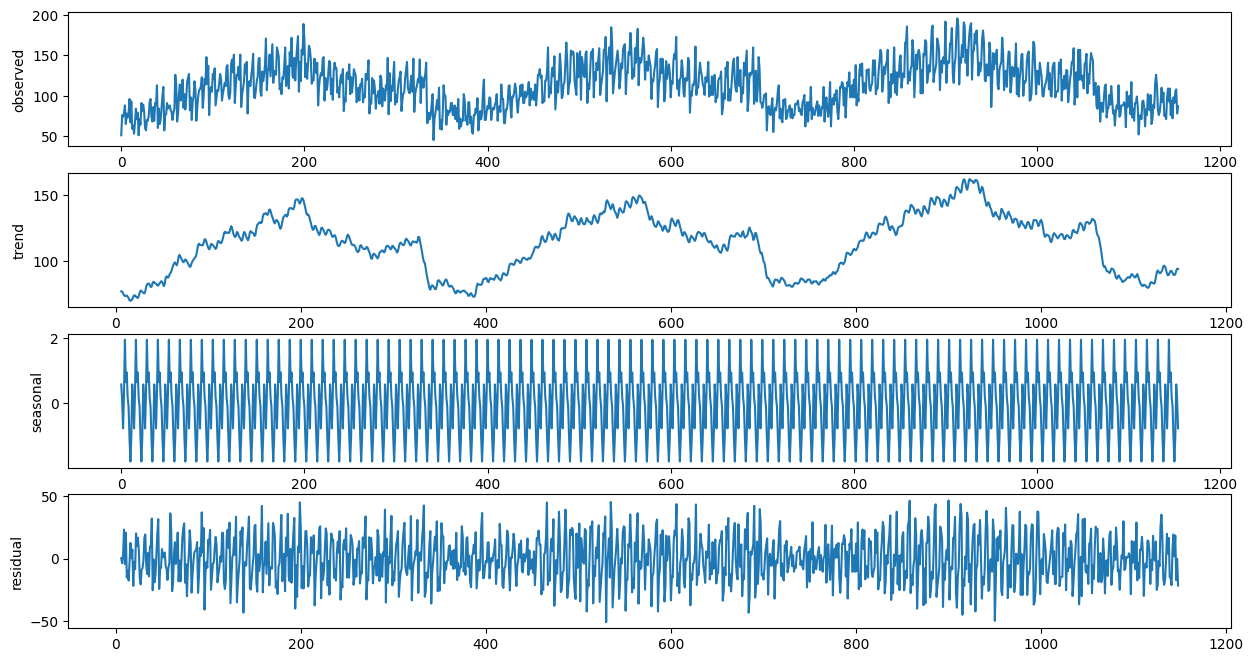

In [24]:
decomp = sm.tsa.seasonal_decompose(mydataset['Qty'], model = 'additive', period = 12)
result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

plt.figure(figsize=(15, 8))

plt.subplot(4,1,1)
plt.plot(result['observed'])
plt.ylabel('observed')

plt.subplot(4,1,2)
plt.plot(result['trend'])
plt.ylabel('trend')

plt.subplot(4,1,3)
plt.plot(result['seasonal'])
plt.ylabel('seasonal')

plt.subplot(4,1,4)
plt.plot(result['residual'])
plt.ylabel('residual')
plt.show()

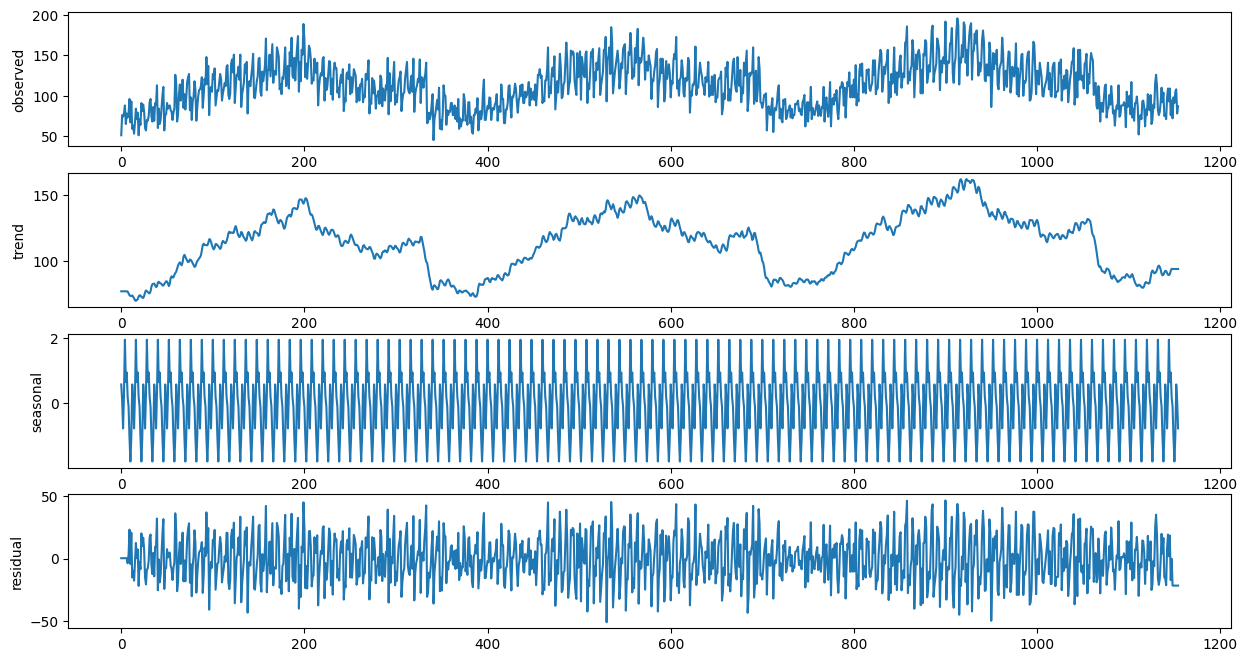

In [25]:
#시계열 분해 데이터
result = result.bfill()
result = result.ffill()

plt.figure(figsize=(15, 8))

plt.subplot(4,1,1)
plt.plot(result['observed'])
plt.ylabel('observed')

plt.subplot(4,1,2)
plt.plot(result['trend'])
plt.ylabel('trend')

plt.subplot(4,1,3)
plt.plot(result['seasonal'])
plt.ylabel('seasonal')

plt.subplot(4,1,4)
plt.plot(result['residual'])
plt.ylabel('residual')
plt.show()

result = result[['trend','seasonal','residual']]

In [26]:
my_dataset = pd.concat([mydataset,result],axis=1)
my_dataset.drop(columns='Date',inplace=True)

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

my_dataset['FutureQty'] = my_dataset['Qty'].shift(-2) # 이틀 뒤의 판매량 예측
target = 'FutureQty'

X = my_dataset.drop(columns=target)
y = my_dataset[target]
X_train = X[:-60]
y_train = y[:-60]
X_valid = X[-60:-2]
y_valid = y[-60:-2]

X_train[['Qty','CustomerCount','WTI_Price','CustomerCount','TotalPrice']] = scaler.fit_transform(X_train[['Qty','CustomerCount','WTI_Price','CustomerCount','TotalPrice']])
X_valid[['Qty','CustomerCount','WTI_Price','CustomerCount','TotalPrice']]= scaler.transform(X_valid[['Qty','CustomerCount','WTI_Price','CustomerCount','TotalPrice']])
X_train

,Qty,WTI_Price,CustomerCount,IsHoliday,IsOverQtyMonth,IsSummer,TotalPrice,year_2015,year_2016,year_2017,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend,seasonal,residual
0,-2.253228,1.374902,-0.738606,1,0,0,-2.253228,0,0,0,...,0,0,0,0,0,0,0,76.750000,0.583969,0.298309
1,-1.363334,1.374902,0.022695,0,0,0,-1.363334,0,0,0,...,0,0,0,0,0,0,0,76.750000,0.091425,0.298309
2,-1.434526,1.314181,-0.325836,0,0,0,-1.434526,0,0,0,...,0,0,0,0,0,0,0,76.750000,-0.767785,0.298309
3,-1.292143,1.292027,1.278773,1,0,0,-1.292143,0,0,0,...,0,0,0,0,0,0,0,76.750000,0.286601,0.298309
4,-0.936185,1.292027,0.980813,1,0,0,-0.936185,0,0,0,...,0,0,0,0,0,0,0,76.750000,1.959408,0.298309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,-1.434526,-0.361381,1.721612,1,0,0,-1.434526,0,1,0,...,0,0,0,0,0,0,1,84.958333,-1.786645,-9.171688
1091,-1.363334,-0.361381,0.368492,0,0,0,-1.363334,0,1,0,...,0,0,0,0,0,0,1,85.166667,-1.029189,-8.137478
1092,-0.936185,-0.312559,1.080589,0,0,0,-0.936185,0,1,0,...,0,0,0,0,0,0,1,86.125000,0.583969,1.291031
1093,-0.936185,-0.321174,0.542074,0,0,0,-0.936185,0,1,0,...,0,0,0,0,0,0,1,87.083333,0.091425,0.825241


In [28]:
timesteps = 14
X_train,y_train = temporalize(X_train,y_train,timesteps)
X_valid,y_valid = temporalize(X_valid,y_valid,timesteps)

* **모델링**

In [29]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping,ModelCheckpoint

model = Sequential()
model.add(LSTM(units=128,return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.0005), loss=MeanSquaredError())
es = EarlyStopping(monitor='val_loss',patience=30)
mc = ModelCheckpoint('CheckPoint/best_lstm.keras',save_best_only=True,monitor='val_loss',mode='min')
# 모델 훈련
model.fit(X_train, y_train,validation_data=[X_valid,y_valid], epochs=100, batch_size=8, callbacks=[es,mc])

# 예측
predictions = model.predict(X_valid)


Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 13188.1494 - val_loss: 5793.7280
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 10529.2793 - val_loss: 4213.5127
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8832.5762 - val_loss: 3224.7334
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7171.5713 - val_loss: 2455.4690
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5976.5659 - val_loss: 1865.7540
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5005.7314 - val_loss: 1394.6754
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4265.0425 - val_loss: 1025.2225
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3751.2239 - val_loss: 742.1052
Epoch 9/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3040.6338 - val_loss: 535.3286
Epoch 10/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2604.6355 - val_loss: 390.8286
Epoch 11/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2203.351

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


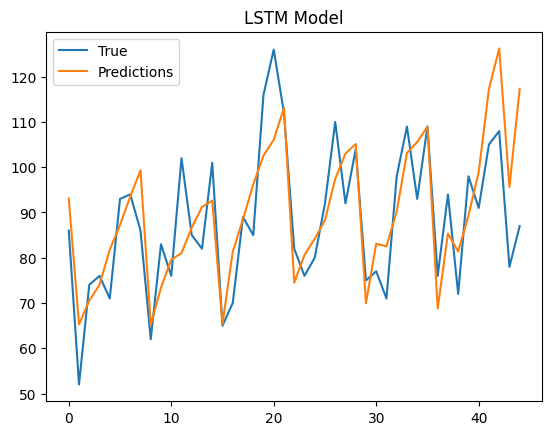

In [30]:
plt.figure()
plt.plot(y_valid,label='True')
plt.plot(predictions[:,0],label='Predictions')
plt.title("LSTM Model")
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import mean_absolute_error,r2_score
print(r2_score(y_valid,predictions))
mean_absolute_error(y_valid,predictions)

0.5376605138974455


8.543890719943576

# **3.데이터 파이프라인 생성 및 비즈니스 평가**

- 파이프라인 함수 생성 및 test 데이터로 확인
- 재고 시뮬레이터 및 예측결과 시뮬레이션(재고금액 평가)

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from pandas.tseries.holiday import USFederalHolidayCalendar

def temporalize(x, y, timesteps):
    """
    시계열 데이터를 3차원으로 변환하는 함수

    Parameters:
    -----------
    x : DataFrame - 특성 데이터
    y : Series - 타겟 데이터
    timesteps : int - 시퀀스 길이

    Returns:
    --------
    output_X : array - 3차원으로 변환된 특성 데이터
    output_y : array - 3차원에 맞춰진 타겟 데이터
    """
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

def create_pipeline(sales, orders, oil_price, products, stores, product_id, y_scale=True, use_3d=True, timesteps=7):
    """
    데이터 파이프라인 함수: 원시 데이터를 받아 모델링에 필요한 형태로 변환

    Parameters:
    -----------
    sales : DataFrame - 판매 데이터
    orders : DataFrame - 주문 데이터
    oil_price : DataFrame - 유가 데이터
    products : DataFrame - 제품 정보 데이터
    stores : DataFrame - 매장 정보 데이터
    product_id : int - 대상 제품 ID (3, 12, 42)
    y_scale : bool - 타겟 변수 스케일링 여부
    use_3d : bool - 3차원 데이터 구조 변환 여부
    timesteps : int - 시퀀스 길이 (3D 데이터 구조에 사용)

    Returns:
    --------
    x_test : array - 특성 데이터
    y_test : array - 타겟 데이터
    y_min : float - 타겟 변수 최소값 (스케일링 시 필요)
    y_max : float - 타겟 변수 최대값 (스케일링 시 필요)
    """

    # 날짜 형식 변환
    sales['Date'] = pd.to_datetime(sales['Date'])
    orders['Date'] = pd.to_datetime(orders['Date'])
    oil_price['Date'] = pd.to_datetime(oil_price['Date'])

    # 제품별 파이프라인 실행
    if product_id == 3:
        return pipeline_product_3(sales, orders, oil_price, products, stores, y_scale, use_3d, timesteps)
    elif product_id == 12:
        return pipeline_product_12(sales, orders, oil_price, products, stores, y_scale, use_3d, timesteps)
    elif product_id == 42:
        return pipeline_product_42(sales, orders, oil_price, products, stores, y_scale, use_3d, timesteps)
    else:
        raise ValueError("지원되지 않는 제품 ID입니다. 3, 12, 42 중 하나를 선택하세요.")

def pipeline_product_3(sales, orders, oil_price, products, stores, y_scale=True, use_3d=True, timesteps=7):
    """제품 3(Beverage)에 대한 데이터 파이프라인"""

    # 필요한 데이터 추출 및 병합
    sales_filtered = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==3), ['Date','Qty']]
    orders_filtered = orders.loc[orders['Store_ID']==44, ['Date','CustomerCount']]
    df = pd.merge(sales_filtered, orders_filtered)

    # 타겟 변수 생성 (LeadTime 2일 고려)
    df['target'] = df['Qty'].shift(-2)
    df.dropna(inplace=True)

    # 날짜 요소 추출
    df['WeekDay'] = df['Date'].dt.day_name()
    df['Month'] = df['Date'].dt.month

    # 동일 카테고리 판매량 합계
    category = products.loc[products['Product_ID'] == 3, 'Category'].iloc[0]
    product_ids = products.loc[products['Category'] == category, 'Product_ID'].tolist()
    category_sales = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID'].isin(product_ids))].groupby('Date', as_index=False)['Qty'].sum()
    category_sales.columns = ['Date', 'Category_Qty']
    df = pd.merge(df, category_sales, how='left')

    # 동일 지역 방문객 수
    city = stores.loc[stores['Store_ID']==44, 'City'].iloc[0]
    store_ids = stores.loc[stores['City']==city, 'Store_ID'].tolist()
    city_customers = orders.loc[orders['Store_ID'].isin(store_ids)].groupby('Date', as_index=False)['CustomerCount'].sum()
    city_customers.columns = ['Date', 'City_CustCount']
    df = pd.merge(df, city_customers, how='left')

    # 유가 데이터 추가
    df = pd.merge(df, oil_price, how='left')
    df['WTI_Price'] = df['WTI_Price'].interpolate(method='linear')

    # 특성과 타겟 분리
    target = 'target'
    X = df.drop(['Date', target], axis=1)
    y = df[target]

    # 가변수화
    X['WeekDay'] = pd.Categorical(X['WeekDay'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    X['Month'] = pd.Categorical(X['Month'], categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    X = pd.get_dummies(X, columns=['WeekDay', 'Month'])

    # 특성 스케일링
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    # 타겟 스케일링
    if y_scale:
        y_min, y_max = y.min(), y.max()
        y_scaled = (y - y_min) / (y_max - y_min)
    else:
        y_scaled = y
        y_min, y_max = None, None

    # 3차원 데이터 구조 변환
    if use_3d:
        X_3d, y_3d = temporalize(X_scaled, y_scaled, timesteps)
        return X_3d, y_3d, y_min, y_max
    else:
        return X_scaled.values, y_scaled.values, y_min, y_max

def pipeline_product_12(sales, orders, oil_price, products, stores, y_scale=True, use_3d=True, timesteps=7):
    """제품 12(Milk)에 대한 데이터 파이프라인"""

    # 필터링 및 데이터 병합
    sales_filtered = sales[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 12)]
    orders_filtered = orders[orders['Store_ID'] == 44]
    df = pd.merge(sales_filtered, orders_filtered, on=['Date', 'Store_ID'], how='inner')

    # 날짜 관련 변수 생성
    df['Month'] = df['Date'].dt.month
    df['Day_of_Week'] = df['Date'].dt.dayofweek
    df['Is_Weekend'] = df['Date'].dt.dayofweek.isin([5, 6]).astype(int)

    # 계절 정보 추가
    def get_season(month):
        if 3 <= month <= 5:
            return 'Spring'
        elif 6 <= month <= 8:
            return 'Summer'
        elif 9 <= month <= 11:
            return 'Autumn'
        else:
            return 'Winter'
    df['Season'] = df['Date'].dt.month.apply(get_season)

    # 미국 연방 공휴일 정보 추가
    holiday_calendar = USFederalHolidayCalendar()
    holidays = holiday_calendar.holidays(start=df['Date'].min(), end=df['Date'].max())
    df['Is_Holiday'] = df['Date'].isin(holidays).astype(int)

    # 타겟 변수 생성 (LeadTime 3일 고려)
    df['Target_Qty'] = df['Qty'].shift(-3)

    # 고객 수 증가율 계산
    df['Customer_Growth'] = df['CustomerCount'].pct_change()

    # 결측치 처리
    df['Target_Qty'] = df['Target_Qty'].fillna(method='ffill')
    df['Customer_Growth'] = df['Customer_Growth'].fillna(0)

    # 유가 데이터 추가
    df = pd.merge(df, oil_price, on='Date', how='left')
    df['WTI_Price'] = df['WTI_Price'].fillna(method='bfill')

    # 필요없는 열 제거
    df.drop(columns=['Store_ID', 'Product_ID'], inplace=True)

    # 특성과 타겟 분리
    target = 'Target_Qty'
    X = df.drop(['Date', target], axis=1)
    y = df[target]

    # 가변수화
    X = pd.get_dummies(X, columns=['Season'], drop_first=True)

    # 스케일링할 컬럼 선택
    num_cols = ['Qty', 'CustomerCount', 'WTI_Price', 'Customer_Growth']

    # 특성 스케일링
    scaler = MinMaxScaler()
    X[num_cols] = scaler.fit_transform(X[num_cols])

    # 타겟 스케일링
    if y_scale:
        y_min, y_max = y.min(), y.max()
        y_scaled = (y - y_min) / (y_max - y_min)
    else:
        y_scaled = y
        y_min, y_max = None, None

    # 3차원 데이터 구조 변환
    if use_3d:
        X_3d, y_3d = temporalize(X, y_scaled, timesteps)
        return X_3d, y_3d, y_min, y_max
    else:
        return X.values, y_scaled.values, y_min, y_max

def pipeline_product_42(sales, orders, oil_price, products, stores, y_scale=True, use_3d=True, timesteps=14):
    """제품 42(Agricultural products)에 대한 데이터 파이프라인"""

    # 데이터 병합
    dataset = pd.merge(sales, products, how='left', on='Product_ID')
    dataset = pd.merge(dataset, stores, how='left', on='Store_ID')
    dataset = pd.merge(dataset, oil_price, how='left', on='Date')
    dataset = pd.merge(dataset, orders, how='left', on=['Date', 'Store_ID'])

    # 필터링
    myinterested = dataset.loc[(dataset['Store_ID']==44) & (dataset['Product_ID']==42)]

    # 불필요한 열 제거
    myinterested.drop(columns=['Product_Code', 'Store_Type', 'SubCategory', 'Category',
                              'Store_ID', 'Product_ID', 'State', 'City', 'LeadTime'],
                     inplace=True)

    # 인덱스 초기화
    myinterested.reset_index(drop=True, inplace=True)

    # 날짜 관련 변수 생성
    myinterested['year'] = myinterested['Date'].dt.year
    myinterested['weekday'] = myinterested['Date'].dt.weekday
    myinterested['month'] = myinterested['Date'].dt.month

    # 공휴일 정보 추가
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays()
    myinterested['holiday'] = np.where((myinterested['weekday'] >= 5) |
                                     (myinterested['Date'].isin(holidays)), 1, 0)

    # 판매량 관련 파생변수 생성
    myinterested['OverQtyMonth'] = myinterested['month'].map({
        1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:0})

    myinterested['Summer'] = myinterested['month'].map({
        5:1, 6:1, 7:1, 8:1, 1:0, 2:0, 3:0, 4:0, 9:0, 10:0, 11:0, 12:0})

    # 결측치 처리
    myinterested['WTI_Price'] = myinterested['WTI_Price'].bfill()

    # KNN 결측치 처리
    imputer = KNNImputer(n_neighbors=3)
    myinterested['CustomerCount'] = imputer.fit_transform(
        myinterested[['Qty', 'CustomerCount', 'holiday']])[:,1]

    # 데이터 타입 변환
    myinterested[['CustomerCount', 'Qty']] = myinterested[['CustomerCount', 'Qty']].astype(int)

    # 열 이름 변경
    myinterested = myinterested.rename(columns={
        'holiday': 'IsHoliday',
        'Summer': 'IsSummer',
        'OverQtyMonth': 'IsOverQtyMonth'
    })

    # 가격 관련 파생변수 생성
    myinterested['TotalPrice'] = myinterested['Price'] * myinterested['Qty']
    myinterested.drop(columns='Price', inplace=True)

    # 시계열 분해
    decomp = sm.tsa.seasonal_decompose(myinterested['Qty'], model='additive', period=12)
    result = pd.DataFrame({
        'trend': decomp.trend,
        'seasonal': decomp.seasonal,
        'residual': decomp.resid
    })

    # 결측치 처리
    result = result.bfill().ffill()

    # 데이터 병합
    myinterested = pd.concat([myinterested, result], axis=1)

    # 타겟 변수 생성 (LeadTime 3일 고려)
    myinterested['FutureQty'] = myinterested['Qty'].shift(-3)

    # 날짜 열 제거
    myinterested.drop(columns='Date', inplace=True)

    # 가변수화
    cat_cols = ['year', 'weekday', 'month']
    myinterested = pd.get_dummies(myinterested, columns=cat_cols, drop_first=True, dtype=int)

    # 특성과 타겟 분리
    target = 'FutureQty'
    X = myinterested.drop(columns=target)
    y = myinterested[target]

    # 특성 스케일링
    scaler = StandardScaler()
    num_cols = ['Qty', 'CustomerCount', 'WTI_Price', 'TotalPrice']
    X[num_cols] = scaler.fit_transform(X[num_cols])

    # 타겟 스케일링
    if y_scale:
        y_min, y_max = y.min(), y.max()
        y_scaled = (y - y_min) / (y_max - y_min)
    else:
        y_scaled = y
        y_min, y_max = None, None

    # 결측치 처리
    X = X.fillna(0)
    y_scaled = y_scaled.fillna(method='ffill')

    # 3차원 데이터 구조 변환
    if use_3d:
        X_3d, y_3d = temporalize(X, y_scaled, timesteps)
        return X_3d, y_3d, y_min, y_max
    else:
        return X.values, y_scaled.values, y_min, y_max

def inv_simulator(y, pred, safe_stock, price):
    """
    재고 시뮬레이터 함수

    Parameters:
    -----------
    y : array - 실제 판매량
    pred : array - 예측 판매량
    safe_stock : int - 안전 재고량
    price : float - 상품 가격

    Returns:
    --------
    inventory : DataFrame - 재고 시뮬레이션 결과
    """

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션
    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[i, 'receive'] = temp.loc[i, 'y']  # 입고량은 실판매량으로 계산
            temp.loc[i, 'base_stock'] = temp.loc[i, 'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[i, 'receive'] = temp.loc[i, 'y'] # 입고량은 실판매량으로 계산
            temp.loc[i, 'base_stock'] = temp.loc[i, 'receive'] + temp.loc[i-1, 'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[i, 'receive'] = temp.loc[i-2, 'order']    # 입고량 = 2일전 발주량
            temp.loc[i, 'base_stock'] = temp.loc[i, 'receive'] + temp.loc[i-1, 'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock > 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order > 0, order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y']) < 0,
                           abs(temp['base_stock'] - temp['y']), 0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(), 3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()

    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

In [36]:
if __name__ == "__main__":
    # 데이터 로드
    path = '/content/drive/MyDrive/project6/'
    oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
    orders_test = pd.read_csv(path + 'test/orders_test.csv')
    sales_test = pd.read_csv(path + 'test/sales_test.csv')
    products = pd.read_csv(path + 'test/products.csv')
    stores = pd.read_csv(path + 'test/stores.csv')

    # 제품 3 (Beverage) - 테스트 및 평가
    print("\n" + "="*50)
    print("제품 3 (Beverage) 평가")
    print("="*50)

    X_test_3, y_test_3, y_min_3, y_max_3 = create_pipeline(
        sales_test, orders_test, oil_price_test, products, stores,
        product_id=3, y_scale=True, use_3d=True, timesteps=7
    )
    print(f"제품 3 테스트 데이터 형태: X={X_test_3.shape}, y={y_test_3.shape}")

    # 예측 및 평가
    pred_3 = model03_01.predict(X_test_3)
    pred_3_real = pred_3 * (y_max_3 - y_min_3) + y_min_3
    y_test_3_real = y_test_3 * (y_max_3 - y_min_3) + y_min_3

    # 성능 지표 출력
    print("\n[제품 3 예측 성능]")
    print('MAE :', mean_absolute_error(y_test_3_real, pred_3_real))
    print('MAPE:', mean_absolute_percentage_error(y_test_3_real, pred_3_real))
    print('R2  :', r2_score(y_test_3_real, pred_3_real))

    # 안전재고 수량을 조절하면서 재고 시뮬레이션 수행
    print("\n[제품 3 재고 시뮬레이션]")
    for safe_stock in [5, 10, 15, 20]:
        print(f"\n안전재고: {safe_stock}")
        inv_3 = inv_simulator(y_test_3_real, pred_3_real, safe_stock=safe_stock, price=8)

    # 제품 12 (Milk) - 테스트 및 평가
    print("\n" + "="*50)
    print("제품 12 (Milk) 평가")
    print("="*50)

    X_test_12, y_test_12, y_min_12, y_max_12 = create_pipeline(
        sales_test, orders_test, oil_price_test, products, stores,
        product_id=12, y_scale=True, use_3d=True, timesteps=7
    )
    print(f"제품 12 테스트 데이터 형태: X={X_test_12.shape}, y={y_test_12.shape}")

    # 예측 및 평가
    pred_12 = model12_02.predict(X_test_12)
    pred_12_real = pred_12 * (y_max_12 - y_min_12) + y_min_12
    y_test_12_real = y_test_12 * (y_max_12 - y_min_12) + y_min_12

    # 성능 지표 출력
    print("\n[제품 12 예측 성능]")
    print('MAE :', mean_absolute_error(y_test_12_real, pred_12_real))
    print('MAPE:', mean_absolute_percentage_error(y_test_12_real, pred_12_real))
    print('R2  :', r2_score(y_test_12_real, pred_12_real))

    # 안전재고 수량을 조절하면서 재고 시뮬레이션 수행
    print("\n[제품 12 재고 시뮬레이션]")
    for safe_stock in [5, 10, 15, 20]:
        print(f"\n안전재고: {safe_stock}")
        inv_12 = inv_simulator(y_test_12_real, pred_12_real, safe_stock=safe_stock, price=6)

    # 제품 42 (Agricultural products) - 테스트 및 평가
    print("\n" + "="*50)
    print("제품 42 (Agricultural products) 평가")
    print("="*50)

    X_test_42, y_test_42, y_min_42, y_max_42 = create_pipeline(
        sales_test, orders_test, oil_price_test, products, stores,
        product_id=42, y_scale=True, use_3d=True, timesteps=14
    )
    print(f"제품 42 테스트 데이터 형태: X={X_test_42.shape}, y={y_test_42.shape}")

    # 예측 및 평가 (모델명은 가정)
    pred_42 = model.predict(X_test_42)  # 모델명이 'model'로 가정
    pred_42_real = pred_42 * (y_max_42 - y_min_42) + y_min_42
    y_test_42_real = y_test_42 * (y_max_42 - y_min_42) + y_min_42

    # 성능 지표 출력
    print("\n[제품 42 예측 성능]")
    print('MAE :', mean_absolute_error(y_test_42_real, pred_42_real))
    print('MAPE:', mean_absolute_percentage_error(y_test_42_real, pred_42_real))
    print('R2  :', r2_score(y_test_42_real, pred_42_real))

    # 안전재고 수량을 조절하면서 재고 시뮬레이션 수행
    print("\n[제품 42 재고 시뮬레이션]")
    for safe_stock in [5, 10, 15, 20]:
        print(f"\n안전재고: {safe_stock}")
        inv_42 = inv_simulator(y_test_42_real, pred_42_real, safe_stock=safe_stock, price=5)

    # 최적 안전재고량 결정 (기회손실이 0에 가장 가까운 값)
    print("\n" + "="*50)
    print("최적 안전재고량 및 재고 금액 요약")
    print("="*50)

    # 여기서는 예시로 최적 안전재고량을 직접 지정
    optimal_ss_3 = 15   # 제품 3의 최적 안전재고량 (예시)
    optimal_ss_12 = 12  # 제품 12의 최적 안전재고량 (예시)
    optimal_ss_42 = 10  # 제품 42의 최적 안전재고량 (예시)

    print("\n[최종 재고 평가]")
    print("\n제품 3 (Beverage):")
    inv_3_final = inv_simulator(y_test_3_real, pred_3_real, safe_stock=optimal_ss_3, price=8)

    print("\n제품 12 (Milk):")
    inv_12_final = inv_simulator(y_test_12_real, pred_12_real, safe_stock=optimal_ss_12, price=6)

    print("\n제품 42 (Agricultural products):")
    inv_42_final = inv_simulator(y_test_42_real, pred_42_real, safe_stock=optimal_ss_42, price=5)


제품 3 (Beverage) 평가
제품 3 테스트 데이터 형태: X=(23, 7, 24), y=(23,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

[제품 3 예측 성능]
MAE : 6757.749639096467
MAPE: 0.5395508023679528
R2  : -2.5999570313628086

[제품 3 재고 시뮬레이션]

안전재고: 5
일평균 재고량     : 2600.929
일평균 재고 금액  : 20807.432
일평균 재고회전율 : 7.468
기회손실 수량     : 136273.0

안전재고: 10
일평균 재고량     : 2603.548
일평균 재고 금액  : 20828.384
일평균 재고회전율 : 7.459
기회손실 수량     : 136183.0

안전재고: 15
일평균 재고량     : 2606.167
일평균 재고 금액  : 20849.336
일평균 재고회전율 : 7.45
기회손실 수량     : 136093.0

안전재고: 20
일평균 재고량     : 2608.786
일평균 재고 금액  : 20870.288
일평균 재고회전율 : 7.441
기회손실 수량     : 136003.0

제품 12 (Milk) 평가
제품 12 테스트 데이터 형태: X=(25, 7, 8), y=(25,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step

[제품 12 예측 성능]
MAE : 7919.61203125
MAPE: 0.6775319245359408
R2  : -6.743768721755578

[제품 12 재고 시뮬레이션]

안전재고: 5
일평균 재고량     : 2002.435
일평균 재고 금액  : 12014.61
일평균 재고회전율 : 12.25
기회손실 수량     : 161085.0

안전재고: 10
일평균 재고량     : 2005.043
일평균 재고 금액  : 12030.258
일평균 재고회전율 : 12.225
기회손실 수량     : 160985.0

안전재고: 15
일평균 재고량 